# LC-MS Deconvolution Results Analysis

This notebook will:

1. Parse your `REVISED.txt` log output  
2. Extract the **aggregated** TP/FP/FN/TN + precision/recall/F1/accuracy per variant-group × model  
3. Build summary tables and bar‐charts  
4. Leave space for interpretation


In [19]:
# 1) standard imports
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# enable inline plotting
%matplotlib inline


In [20]:
# 2) read the entire log file into a list of lines
log_path = "REVISED.txt"
with open(log_path, "r") as f:
    lines = [l.rstrip("\n") for l in f]


In [21]:
# %%
# 3) compile regexes for the "AGGREGATED" blocks
import re

agg_header = re.compile(
    r"\*\*\* AGGREGATED \[(?P<model>.+?)\] for '(?P<group>.+?)' \*\*\*"
)
metrics_re = re.compile(
    r"\s*TP=(?P<tp>\d+), FP=(?P<fp>\d+), FN=(?P<fn>\d+), TN=(?P<tn>\d+)"
)
scores_re = re.compile(
    r"\s*Precision=(?P<precision>\d+\.\d+), Recall=(?P<recall>\d+\.\d+), "
    r"F1=(?P<f1>\d+\.\d+), Accuracy=(?P<accuracy>\d+\.\d+)"
)

records = []
current = None

for line in lines:
    # use search() instead of match() so we find the patterns anywhere in the line
    m = agg_header.search(line)
    if m:
        current = {"model": m.group("model"), "group": m.group("group")}
        continue

    if current:
        mm = metrics_re.search(line)
        if mm:
            d = {k: int(v) for k, v in mm.groupdict().items()}
            current.update(d)
            continue

        ms = scores_re.search(line)
        if ms:
            d = {k: float(v) for k, v in ms.groupdict().items()}
            current.update(d)
            records.append(current)
            current = None

# make DataFrame
df = pd.DataFrame(records)
df


,model,group,tp,fp,fn,tn,precision,recall,f1,accuracy
0,GMM,Variant - Two clearly separated peaks,0,0,0,10,0.00,0.0,0.00,1.00
1,RidgeWalker,Variant - Two clearly separated peaks,0,0,0,10,0.00,0.0,0.00,1.00
2,Wavelet,Variant - Two clearly separated peaks,0,0,0,10,0.00,0.0,0.00,1.00
3,GMM,Variant - Strong overlap between two peaks,2,0,3,0,1.00,0.4,0.57,0.40
4,RidgeWalker,Variant - Strong overlap between two peaks,5,0,0,0,1.00,1.0,1.00,1.00
5,Wavelet,Variant - Strong overlap between two peaks,1,0,4,0,1.00,0.2,0.33,0.20
6,GMM,"Variant - Four peaks: 2 overlap, 2 isolated",5,1,0,9,0.83,1.0,0.91,0.93
7,RidgeWalker,"Variant - Four peaks: 2 overlap, 2 isolated",5,2,0,8,0.71,1.0,0.83,0.87
8,Wavelet,"Variant - Four peaks: 2 overlap, 2 isolated",5,1,0,9,0.83,1.0,0.91,0.93
9,GMM,Variant - Cluster of 3 overlapping peaks,5,0,0,0,1.00,1.0,1.00,1.00


In [22]:
# 4) Quick check: what groups and models do we have?
print("Groups:", df["group"].unique())
print("Models:", df["model"].unique())


Groups: ['Variant - Two clearly separated peaks'
 'Variant - Strong overlap between two peaks'
 'Variant - Four peaks: 2 overlap, 2 isolated'
 'Variant - Cluster of 3 overlapping peaks'
 'Variant - Close but not overlapping peaks'
 'Variant - Intense + weak overlap'
 'Variant - Five peaks: 3 spaced, 2 overlapping']
Models: ['GMM' 'RidgeWalker' 'Wavelet']


In [23]:
# 5) Pivot out F1-scores into a clean table
f1_table = df.pivot(index="group", columns="model", values="f1")
f1_table


model,GMM,RidgeWalker,Wavelet
group,,,
Variant - Close but not overlapping peaks,0.00,0.00,0.00
Variant - Cluster of 3 overlapping peaks,1.00,1.00,1.00
"Variant - Five peaks: 3 spaced, 2 overlapping",0.00,0.00,0.00
"Variant - Four peaks: 2 overlap, 2 isolated",0.91,0.83,0.91
Variant - Intense + weak overlap,0.33,0.67,0.89
Variant - Strong overlap between two peaks,0.57,1.00,0.33
Variant - Two clearly separated peaks,0.00,0.00,0.00


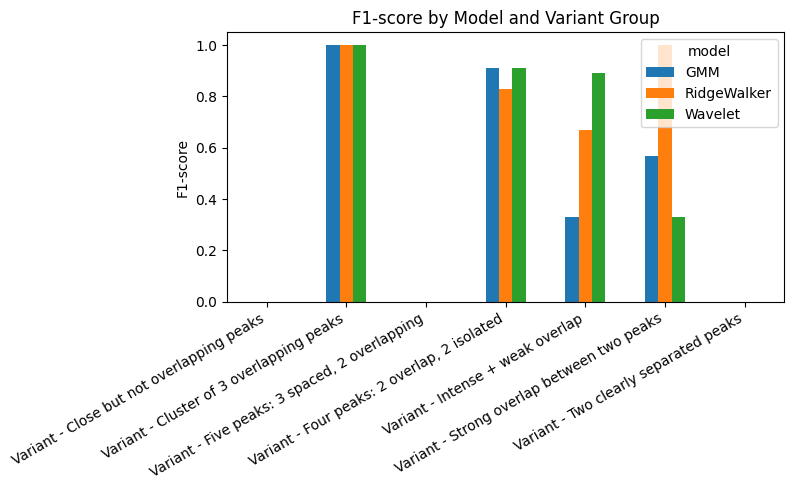

In [24]:
# 6) Bar chart of F1 by variant & model
ax = f1_table.plot(kind="bar", figsize=(8,5))
ax.set_title("F1-score by Model and Variant Group")
ax.set_ylabel("F1-score")
ax.set_xlabel("")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()


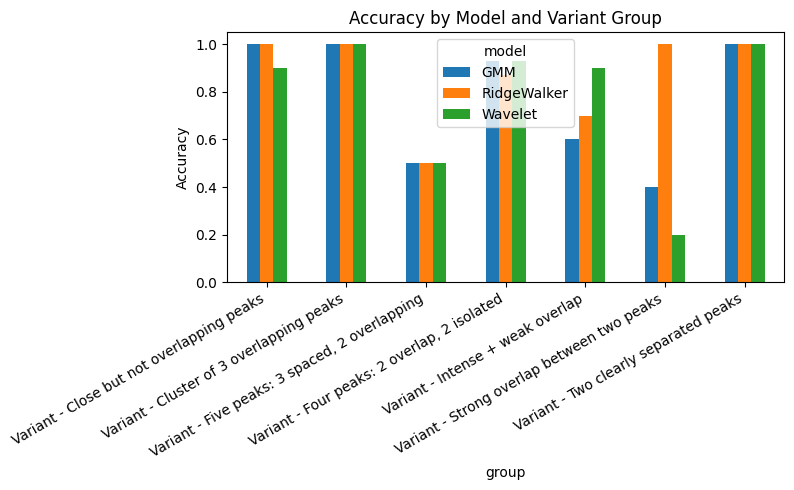

In [25]:
# 7) Similarly, pivot & plot accuracy
acc_table = df.pivot(index="group", columns="model", values="accuracy")
ax = acc_table.plot(kind="bar", figsize=(8,5))
ax.set_title("Accuracy by Model and Variant Group")
ax.set_ylabel("Accuracy")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()


In [26]:
# 8) If you want the raw confusion‐matrix counts in a table:
cm = df.set_index(["group","model"])[["tp","fp","fn","tn"]]
cm.unstack("model")


tp                      fp  \
model                                         GMM RidgeWalker Wavelet GMM   
group                                                                       
Variant - Close but not overlapping peaks       0           0       0   0   
Variant - Cluster of 3 overlapping peaks        5           5       5   0   
Variant - Five peaks: 3 spaced, 2 overlapping   0           0       0   5   
Variant - Four peaks: 2 overlap, 2 isolated     5           5       5   1   
Variant - Intense + weak overlap                1           3       4   0   
Variant - Strong overlap between two peaks      2           5       1   0   
Variant - Two clearly separated peaks           0           0       0   0   

                                                                   fn  \
model                                         RidgeWalker Wavelet GMM   
group                                                                   
Variant - Close but not overlapping peaks               0       1   0   
Variant - Cluster of 3 overlapping peaks                0       0   0   
Variant - Five peaks: 3 spaced, 2 overlapping           5       5   5   
Variant - Four peaks: 2 overlap, 2 isolated             2       1   0   
Variant - Intense + weak overlap                        1       0   4   
Variant - Strong overlap between two peaks              0       0   3   
Variant - Two clearly separated peaks                   0       0   0   

                                                                   tn  \
model                                         RidgeWalker Wavelet GMM   
group                                                                   
Variant - Close but not overlapping peaks               0       0  10   
Variant - Cluster of 3 overlapping peaks                0       0   0   
Variant - Five peaks: 3 spaced, 2 overlapping           5       5  10   
Variant - Four peaks: 2 overlap, 2 isolated             0       0   9   
Variant - Intense + weak overlap                        2       1   5   
Variant - Strong overlap between two peaks              0       4   0   
Variant - Two clearly separated peaks                   0       0  10   

                                                                   
model                                         RidgeWalker Wavelet  
group                                                              
Variant - Close but not overlapping peaks              10       9  
Variant - Cluster of 3 overlapping peaks                0       0  
Variant - Five peaks: 3 spaced, 2 overlapping          10      10  
Variant - Four peaks: 2 overlap, 2 isolated             8       9  
Variant - Intense + weak overlap                        4       5  
Variant - Strong overlap between two peaks              0       0  
Variant - Two clearly separated peaks                  10      10


9) Confusion-Matrix Breakdown
 Plot TP/FP/FN/TN counts side by side for each model & variant.




C:\Users\victo\AppData\Local\Temp\ipykernel_23540\2667098090.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=cm_long, x="group", y="count", hue="metric", ci=None)
c:\Users\victo\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\victo\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\victo\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.p

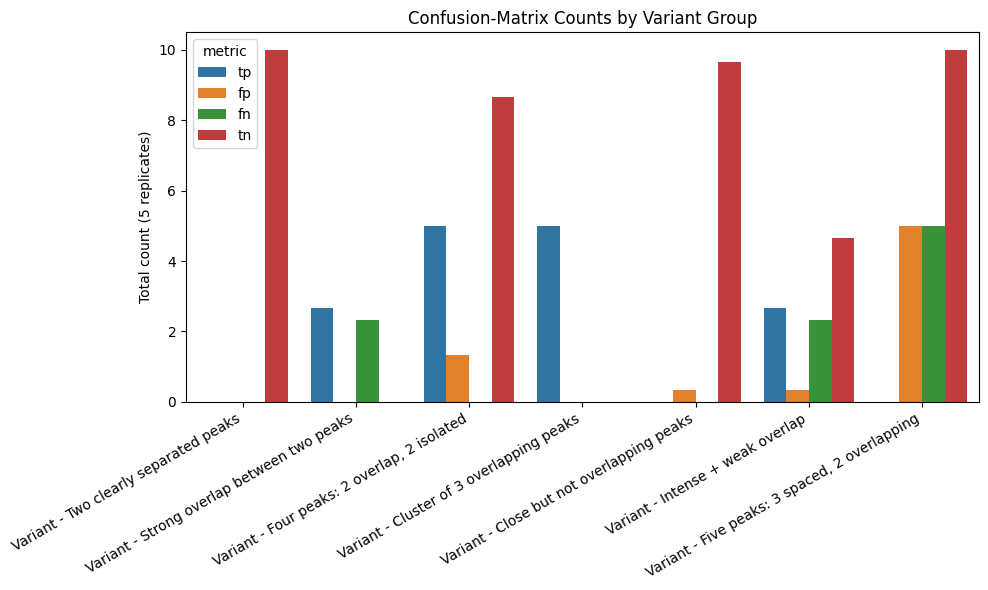

In [27]:
# Cell 9: Confusion‐Matrix Counts by Variant (over all 5 replicates per group)
import seaborn as sns

# melt the tp/fp/fn/tn counts into long form
cm_long = df.melt(
    id_vars=["group","model"],
    value_vars=["tp","fp","fn","tn"],
    var_name="metric",
    value_name="count"
)

plt.figure(figsize=(10,6))
sns.barplot(data=cm_long, x="group", y="count", hue="metric", ci=None)
plt.title("Confusion‐Matrix Counts by Variant Group")
plt.xticks(rotation=30, ha="right")
plt.ylabel("Total count (5 replicates)")
plt.xlabel("")
plt.tight_layout()


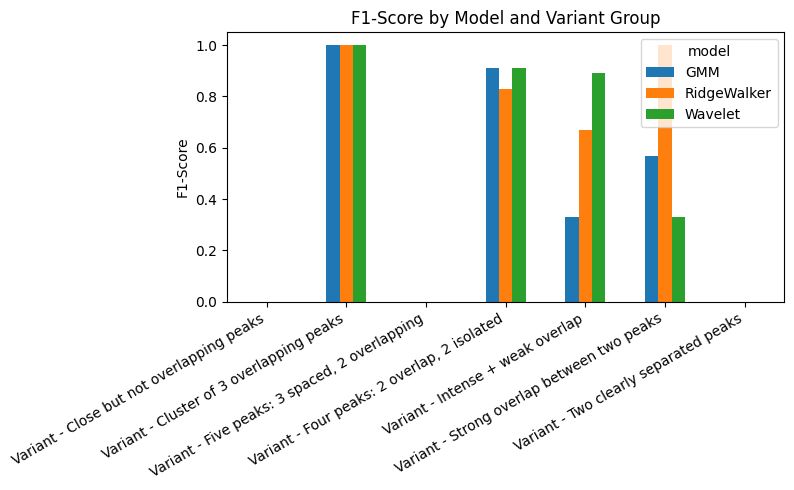

In [28]:
# %% 
# Cell 10: F1‐Score Bar Chart by Model × Variant
f1_table = df.pivot(index="group", columns="model", values="f1")
ax = f1_table.plot(kind="bar", figsize=(8,5))
ax.set_title("F1‐Score by Model and Variant Group")
ax.set_ylabel("F1‐Score")
ax.set_xlabel("")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()


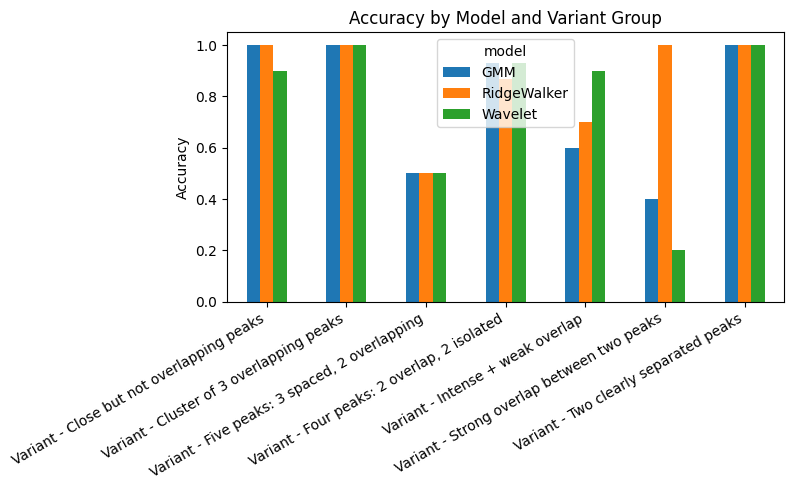

In [29]:
# %% 
# Cell 11: Accuracy Bar Chart by Model × Variant
acc_table = df.pivot(index="group", columns="model", values="accuracy")
ax = acc_table.plot(kind="bar", figsize=(8,5))
ax.set_title("Accuracy by Model and Variant Group")
ax.set_ylabel("Accuracy")
ax.set_xlabel("")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()

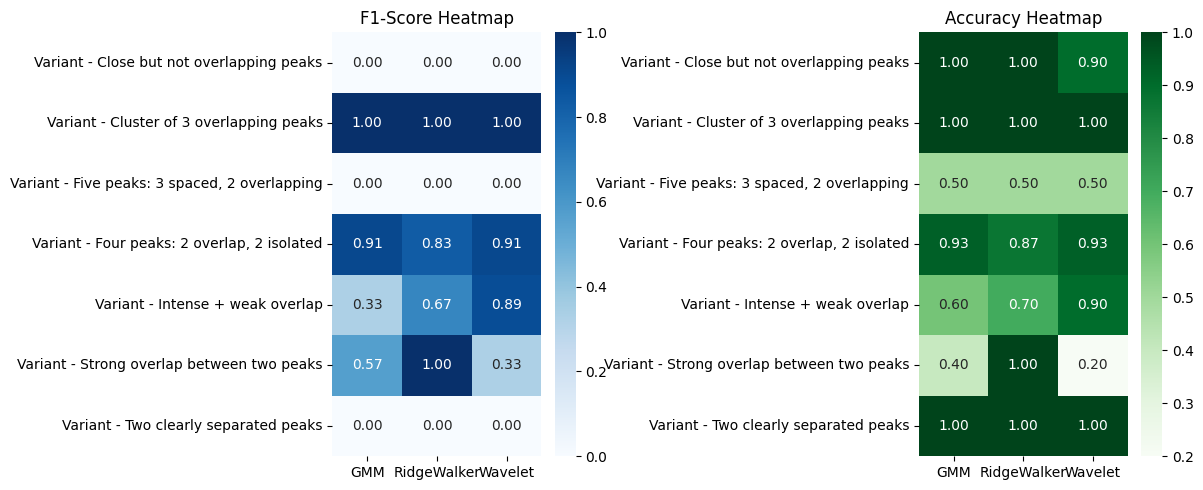

In [30]:
# %% 
# Cell 12: Heatmaps of F1 and Accuracy for Quick Comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

sns.heatmap(f1_table, annot=True, fmt=".2f", cmap="Blues", ax=ax1)
ax1.set_title("F1‐Score Heatmap")
ax1.set_xlabel("")
ax1.set_ylabel("")

sns.heatmap(acc_table, annot=True, fmt=".2f", cmap="Greens", ax=ax2)
ax2.set_title("Accuracy Heatmap")
ax2.set_xlabel("")
ax2.set_ylabel("")

plt.tight_layout()

In [31]:
""" # %% 
# Cell 13: Save Summary Tables and Figures
f1_table.to_csv("f1_summary.csv")
acc_table.to_csv("accuracy_summary.csv")
fig.savefig("heatmaps_f1_accuracy.png", dpi=300)

# also save the confusion‐matrix bar chart
plt.figure(figsize=(10,6))
sns.barplot(data=cm_long, x="group", y="count", hue="metric", ci=None)
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.savefig("confusion_counts.png", dpi=300) """

' # %% \n# Cell 13: Save Summary Tables and Figures\nf1_table.to_csv("f1_summary.csv")\nacc_table.to_csv("accuracy_summary.csv")\nfig.savefig("heatmaps_f1_accuracy.png", dpi=300)\n\n# also save the confusion‐matrix bar chart\nplt.figure(figsize=(10,6))\nsns.barplot(data=cm_long, x="group", y="count", hue="metric", ci=None)\nplt.xticks(rotation=30, ha="right")\nplt.tight_layout()\nplt.savefig("confusion_counts.png", dpi=300) '